In [21]:
# PyTorch and torchvision
import torch
import torchvision

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print('=3')

=3


In [22]:
# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [23]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -O ~/work/data_augmentation/data/images.tar
!tar -xf ~/work/data_augmentation/data/images.tar -C ~/work/data_augmentation/data/

--2025-11-17 02:29:34--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘/home/jovyan/work/data_augmentation/data/images.tar’

/home/jovyan/work/d 100%[===================>] 756.82M  14.1MB/s    in 58s     

2025-11-17 02:30:32 (13.1 MB/s) - ‘/home/jovyan/work/data_augmentation/data/images.tar’ saved [793579520/793579520]



In [24]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

dataset_dir = "~/work/data_augmentation/data/Images/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
])
full_dataset = ImageFolder(root=dataset_dir, transform=transform)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # 약 12,000개
test_size = total_size - train_size   # 약 8,580개
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(ds_train, batch_size=64, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=64, shuffle=False)
ds_info = {
    "num_classes": len(full_dataset.classes),
    "class_names": full_dataset.classes
}

print("=3")

=3


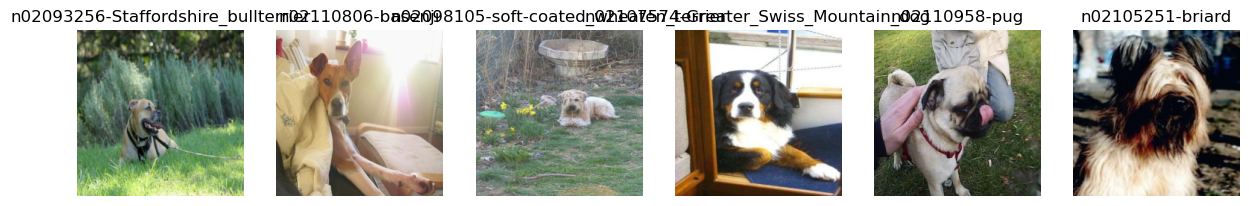

In [25]:
# DataLoader에서 일부 배치 가져오기
def show_examples(data_loader, class_names, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
        image = (image * 0.5) + 0.5
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_names[labels[i].item()])

    plt.show()

# 훈련 데이터 샘플 시각화
show_examples(train_loader, ds_info["class_names"])

In [61]:
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 통일
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
    ])

In [62]:
def augment():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2)
    ])

print('=3')

=3


In [63]:
# 데이터셋을 가공하는 메인함수
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):
    transform = normalize_and_resize_img()

    if not is_test and with_aug:
        dataset.dataset.transform = transforms.Compose([
            *augment().transforms,
            *transform.transforms
        ])
    else:
        dataset.dataset.transform = transform

    return DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

print('=3')

=3


In [64]:
import random

def augment2():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.5),    # 상하 반전
        transforms.RandomRotation(degrees=(0, 90, 180, 270)),  # 90도 단위 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 밝기, 대비, 색상 조정
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 랜덤 크롭 후 리사이즈
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 0~1 값으로 클리핑
    ])

print('=3')

=3


In [65]:
import torch.nn as nn
import torchvision.models as models

num_classes = len(ds_info["class_names"])
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

model = nn.Sequential(
    resnet50,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(resnet50.fc.in_features, num_classes),
    nn.Softmax(dim=1)
)

print("=3")

=3


In [66]:
aug_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
aug_resnet50.fc = nn.Linear(aug_resnet50.fc.in_features, num_classes)

aug_resnet50 = nn.Sequential(
    aug_resnet50,
    nn.Softmax(dim=1)
)

print("=3")

=3


In [67]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

print("=3")

=3


In [68]:
%%time
import torch.optim as optim

#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001)

def train(model, train_loader, test_loader, epochs):
    model.to(device)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history

history_resnet50_no_aug = train(resnet50, ds_train_no_aug, ds_test, EPOCH)

Epoch [1/20], Accuracy: 14.56%
Validation Accuracy: 40.97%
Epoch [2/20], Accuracy: 46.31%
Validation Accuracy: 60.31%
Epoch [3/20], Accuracy: 61.31%
Validation Accuracy: 68.80%
Epoch [4/20], Accuracy: 68.62%
Validation Accuracy: 73.58%
Epoch [5/20], Accuracy: 73.97%
Validation Accuracy: 78.37%
Epoch [6/20], Accuracy: 77.39%
Validation Accuracy: 79.98%
Epoch [7/20], Accuracy: 79.89%
Validation Accuracy: 81.27%
Epoch [8/20], Accuracy: 81.87%
Validation Accuracy: 81.78%
Epoch [9/20], Accuracy: 83.35%
Validation Accuracy: 82.18%
Epoch [10/20], Accuracy: 84.61%
Validation Accuracy: 82.54%
Epoch [11/20], Accuracy: 86.23%
Validation Accuracy: 83.15%
Epoch [12/20], Accuracy: 87.32%
Validation Accuracy: 82.84%
Epoch [13/20], Accuracy: 89.22%
Validation Accuracy: 83.05%
Epoch [14/20], Accuracy: 90.45%
Validation Accuracy: 83.36%
Epoch [15/20], Accuracy: 91.03%
Validation Accuracy: 83.55%
Epoch [16/20], Accuracy: 91.75%
Validation Accuracy: 83.48%
Epoch [17/20], Accuracy: 92.91%
Validation Accura

In [69]:
%%time
history_resnet50_aug = train(aug_resnet50, ds_train_aug, ds_test, EPOCH)

Epoch [1/20], Accuracy: 0.77%
Validation Accuracy: 0.83%
Epoch [2/20], Accuracy: 0.76%
Validation Accuracy: 0.83%
Epoch [3/20], Accuracy: 0.77%
Validation Accuracy: 0.75%
Epoch [4/20], Accuracy: 0.76%
Validation Accuracy: 0.73%
Epoch [5/20], Accuracy: 0.81%
Validation Accuracy: 0.77%
Epoch [6/20], Accuracy: 0.78%
Validation Accuracy: 0.71%
Epoch [7/20], Accuracy: 0.73%
Validation Accuracy: 0.80%
Epoch [8/20], Accuracy: 0.77%
Validation Accuracy: 0.71%
Epoch [9/20], Accuracy: 0.80%
Validation Accuracy: 0.75%
Epoch [10/20], Accuracy: 0.70%
Validation Accuracy: 0.71%
Epoch [11/20], Accuracy: 0.78%
Validation Accuracy: 0.75%
Epoch [12/20], Accuracy: 0.85%
Validation Accuracy: 0.76%
Epoch [13/20], Accuracy: 0.83%
Validation Accuracy: 0.71%
Epoch [14/20], Accuracy: 0.73%
Validation Accuracy: 0.75%
Epoch [15/20], Accuracy: 0.74%
Validation Accuracy: 0.78%
Epoch [16/20], Accuracy: 0.83%
Validation Accuracy: 0.73%
Epoch [17/20], Accuracy: 0.82%
Validation Accuracy: 0.71%
Epoch [18/20], Accuracy

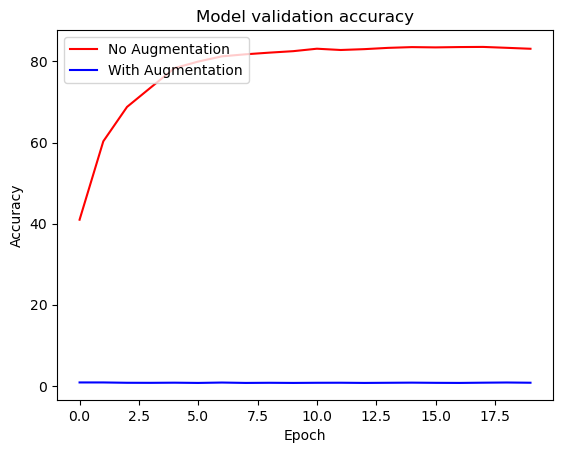

In [70]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

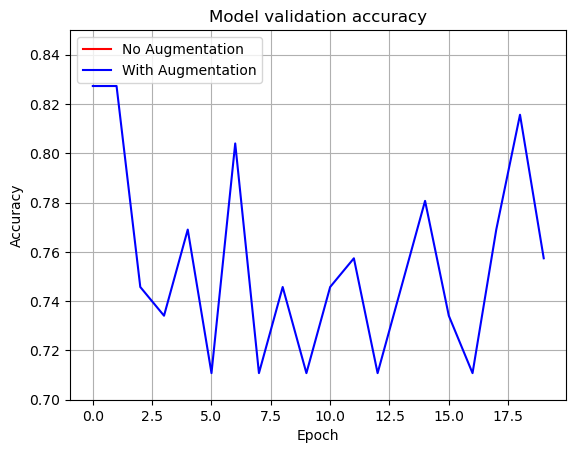

In [72]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0.70, 0.85)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

그래프와 같이 augmentation을 사용했을 때 오히여 accuracy가 비정상적인 문제를 발견했습니다.

#cut mix

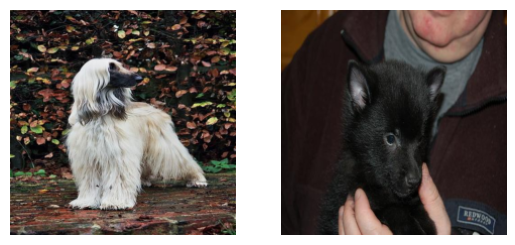

In [73]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다.
data_iter = iter(ds_train_no_aug)
images, labels = next(data_iter)

# 첫 번째 배치에서 두 개의 이미지 선택
image_a = images[0].permute(1, 2, 0).numpy()
image_b = images[1].permute(1, 2, 0).numpy()
label_a = labels[0].item()
label_b = labels[1].item()

# 정규화된 텐서를 다시 [0, 1] 범위로 조정
image_a = (image_a * 0.5) + 0.5
image_b = (image_b * 0.5) + 0.5

# 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(image_a)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_b)
plt.axis('off')

plt.show()

In [74]:
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x :', x_min, x_max)
print('y :', y_min, y_max)

x : 2 3
y : 108 224


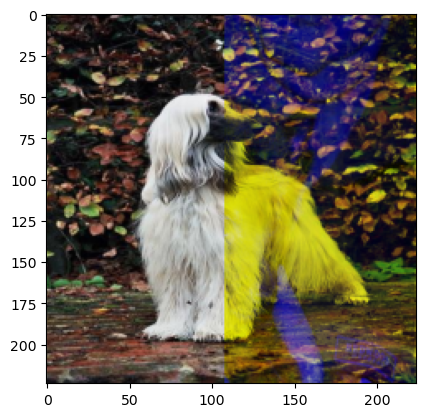

In [75]:
import torch

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    if isinstance(image_a, np.ndarray):
        image_a = torch.from_numpy(image_a).to(device)
    if isinstance(image_b, np.ndarray):
        image_b = torch.from_numpy(image_b).to(device)

    top = image_a[:, :y_min, :]
    middle_left = image_a[:, y_min:y_max, :x_min]
    middle_center = image_b[:, y_min:y_max, x_min:x_max]
    middle_right = image_a[:, y_min:y_max, x_max:]
    bottom = image_a[:, y_max:, :]

    top = top.to(device)
    middle_left = middle_left.to(device)
    middle_center = middle_center.to(device)
    middle_right = middle_right.to(device)
    bottom = bottom.to(device)

    # 중간 부분(왼쪽, 중앙, 오른쪽) 결합
    middle = torch.cat([middle_left, middle_center, middle_right], dim=2)

    # 전체 이미지 결합 (위 + 중간 + 아래)
    mixed_img = torch.cat([top, middle, bottom], dim=1)

    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.cpu().numpy())
plt.show()

라벨 섞기

In [76]:
import torch.nn.functional as F

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # 바운딩 박스 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

     # 원-핫 벡터 변환
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 비율에 따라 라벨 혼합
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

# 예제 실행
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
print(mixed_label)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.8274, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1726, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [77]:
def cutmix(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        j = torch.randint(0, batch_size, (1,)).item()  # 다른 샘플 선택
        image_b = images[j]
        label_b = labels[j]

        # 바운딩 박스 생성
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    # 텐서 변환
    mixed_imgs = torch.stack(mixed_imgs).reshape(batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).reshape(batch_size, num_classes)

    return mixed_imgs, mixed_labels

print("=3")

=3


In [78]:
# 기존 노트북에 정의된 onehot 함수 (그대로 사용)
def onehot(label, num_classes=120):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# 올바르게 수정된 CutMix 함수
def cutmix(data, targets, num_classes, alpha=1.0):
    """
    data: 이미지 배치 (B, C, H, W)
    targets: 레이블 배치 (B,) - 클래스 인덱스
    num_classes: 총 클래스 수
    alpha: CutMix의 베타 분포 파라미터
    """
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # 베타 분포에서 람다 샘플링
    lam = np.random.beta(alpha, alpha)

    # 바운딩 박스 계산
    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    # 이미지 믹스
    mixed_data = data.clone()
    mixed_data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]

    # 람다 값 (실제 섞인 비율) 재계산
    lam = 1 - ((x1 - x0) * (y1 - y0) / (image_w * image_h))

    # 레이블을 One-Hot으로 변환 후 믹스
    targets_onehot = torch.nn.functional.one_hot(targets, num_classes=num_classes).float().to(data.device)
    shuffled_targets_onehot = torch.nn.functional.one_hot(shuffled_targets, num_classes=num_classes).float().to(data.device)
    
    mixed_targets = lam * targets_onehot + (1 - lam) * shuffled_targets_onehot
    
    return mixed_data, mixed_targets

In [79]:
# --- [수정됨] 2. ResNet-50 모델 및 데이터 로더 준비 (전체) ---
# NameError를 해결하기 위해 데이터셋 정의 코드를 포함합니다.

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F # onehot, kl_div에 필요

# --- 이 변수들은 이미 노트북에 정의되어 있다고 가정합니다 (device) ---
# device = 'cuda'
# --------------------------------------------------------

# 1. 원본 노트북의 데이터셋 정의 (셀 24의 로직)
dataset_dir = "~/work/data_augmentation/data/Images/"

# 원본의 기본 transform (ResNet에 맞게 ImageNet 통계로 수정)
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(root=dataset_dir, transform=original_transform)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)
test_size = total_size - train_size

# (중요!) 원본 노트북의 ds_train, ds_test 변수명을 사용합니다.
# 이 변수들이 이제 이 셀에 정의되었습니다.
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

# 2. 새로운 Transform 정의 (CutMix용)

# 학습용 (기본 증강 포함)
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 평가용 (증강 없음)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3. 데이터 로더 생성 (!! 중요: 여기서 Transform을 올바르게 설정)

# (1) 학습 로더용: ds_train의 transform을 'transform_aug'로 설정
# (ds_train.dataset은 full_dataset을 가리킴)
ds_train.dataset.transform = transform_aug
train_loader_cutmix = DataLoader(ds_train, batch_size=16, shuffle=True)

# (2) 테스트 로더용: ds_test의 transform을 'basic_transform'으로 설정
# (ds_train과 ds_test는 같은 .dataset을 공유하므로, transform을 다시 바꿔야 함)
ds_test.dataset.transform = basic_transform
test_loader_cutmix = DataLoader(ds_test, batch_size=16, shuffle=False)

# 4. ResNet-50 모델, 옵티마이저, 손실 함수 정의
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
num_classes = 120 # 원본 노트북 ds_info에서 확인
model_resnet50.fc = torch.nn.Linear(num_ftrs, num_classes)
model_resnet50 = model_resnet50.to(device)

optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=1e-4)

# (중요) CutMix의 소프트 레이블을 위한 손실 함수
def train_loss_fn(outputs, soft_targets):
    return F.kl_div(
        F.log_softmax(outputs, dim=1),
        soft_targets,
        reduction='batchmean'
    )

# 평가용 (기존과 동일)
eval_loss_fn = torch.nn.CrossEntropyLoss().to(device)

print("ResNet-50 모델 및 CutMix 데이터 로더 준비 완료.")
print(f"학습 데이터셋: {len(ds_train)}개, 테스트 데이터셋: {len(ds_test)}개")
print("참고: 학습 로더는 'transform_aug'를, 테스트 로더는 'basic_transform'을 사용합니다.")

ResNet-50 모델 및 CutMix 데이터 로더 준비 완료.
학습 데이터셋: 11998개, 테스트 데이터셋: 8582개
참고: 학습 로더는 'transform_aug'를, 테스트 로더는 'basic_transform'을 사용합니다.


In [80]:
# (가정) 이전에 정의한 변수들이 모두 존재해야 합니다:
# model_resnet50, device, train_loader_cutmix, test_loader_cutmix,
# optimizer_resnet50, train_loss_fn, eval_loss_fn, num_classes

num_epochs = 20

# 1. 결과를 저장할 history 딕셔너리 생성
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Starting ResNet-50 training with CutMix (and history logging)...")

for epoch in range(num_epochs):
    
    # --- 학습 (Train) ---
    model_resnet50.train()
    running_train_loss = 0.0
    running_train_corrects = 0
    
    for images, labels in train_loader_cutmix:
        images = images.to(device)
        labels = labels.to(device) # (B,)
        
        # CutMix 적용
        mixed_images, mixed_labels = cutmix(images, labels, num_classes)
        
        optimizer_resnet50.zero_grad()
        
        # 모델 순전파
        outputs = model_resnet50(mixed_images)
        
        # 손실 계산 (CutMix용 소프트 손실)
        loss = train_loss_fn(outputs, mixed_labels)
        
        loss.backward()
        optimizer_resnet50.step()
        
        # (추가) 학습 정확도 계산 (예측은 mixed_images에서, 정답은 원본 labels에서)
        _, preds = torch.max(outputs, 1)
        running_train_corrects += torch.sum(preds == labels.data)
        
        running_train_loss += loss.item() * images.size(0)

    # 에포크별 학습 손실 및 정확도
    epoch_train_loss = running_train_loss / len(train_loader_cutmix.dataset)
    epoch_train_acc = running_train_corrects.double() / len(train_loader_cutmix.dataset)

    # --- 평가 (Evaluate) ---
    model_resnet50.eval()
    running_val_loss = 0.0
    running_val_corrects = 0
    
    with torch.no_grad():
        for images, labels in test_loader_cutmix:
            images = images.to(device)
            labels = labels.to(device) # (B,)
            
            outputs = model_resnet50(images)
            
            # (추가) 검증 손실 계산 (평가용 하드 손실)
            loss = eval_loss_fn(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            
            # 검증 정확도 계산
            _, preds = torch.max(outputs, 1)
            running_val_corrects += torch.sum(preds == labels.data)

    # 에포크별 검증 손실 및 정확도
    epoch_val_loss = running_val_loss / len(test_loader_cutmix.dataset)
    epoch_val_acc = running_val_corrects.double() / len(test_loader_cutmix.dataset)
    
    # 2. History에 결과 기록
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.cpu().numpy()) # .cpu() 추가
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.cpu().numpy()) # .cpu() 추가
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print("Finished Training.")

Starting ResNet-50 training with CutMix (and history logging)...
Epoch [1/20] | Train Loss: 2.9105 | Train Acc: 0.2643 | Val Loss: 1.2630 | Val Acc: 0.6500
Epoch [2/20] | Train Loss: 2.1854 | Train Acc: 0.4056 | Val Loss: 1.1098 | Val Acc: 0.6866
Epoch [3/20] | Train Loss: 1.9496 | Train Acc: 0.4752 | Val Loss: 1.1012 | Val Acc: 0.6905
Epoch [4/20] | Train Loss: 1.7745 | Train Acc: 0.5120 | Val Loss: 1.0033 | Val Acc: 0.7155
Epoch [5/20] | Train Loss: 1.6636 | Train Acc: 0.5320 | Val Loss: 1.0381 | Val Acc: 0.7138
Epoch [6/20] | Train Loss: 1.5571 | Train Acc: 0.5694 | Val Loss: 1.0160 | Val Acc: 0.7179
Epoch [7/20] | Train Loss: 1.5051 | Train Acc: 0.5859 | Val Loss: 1.0735 | Val Acc: 0.7103
Epoch [8/20] | Train Loss: 1.4201 | Train Acc: 0.6034 | Val Loss: 1.0541 | Val Acc: 0.7189
Epoch [9/20] | Train Loss: 1.3606 | Train Acc: 0.6143 | Val Loss: 1.1082 | Val Acc: 0.7030
Epoch [10/20] | Train Loss: 1.3133 | Train Acc: 0.6211 | Val Loss: 1.1237 | Val Acc: 0.7093
Epoch [11/20] | Train Lo

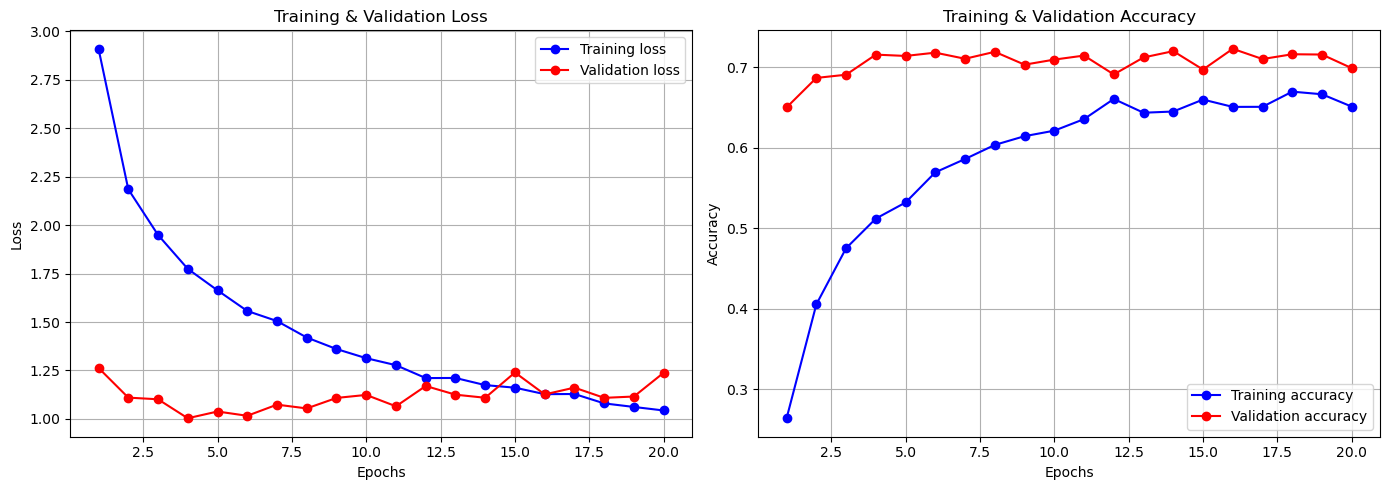

In [81]:
import matplotlib.pyplot as plt

# 1. 시각화할 데이터 가져오기
train_loss = history['train_loss']
val_loss = history['val_loss']
train_acc = history['train_acc']
val_acc = history['val_acc']
epochs = range(1, len(train_loss) + 1)

# 2. 그래프 그리기 (1x2 Subplot)
plt.figure(figsize=(14, 5))

# (왼쪽) 손실(Loss) 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# (오른쪽) 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# 3. 그래프 표시
plt.tight_layout() # 그래프 간격 자동 조절
plt.show()

#mix up

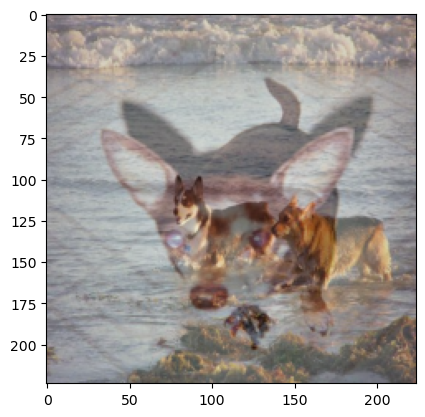

tensor([0.4548, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [46]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()  # 0~1 사이의 랜덤 값

    # 라벨 원핫 인코딩
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

# 예제 실행
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img)
plt.show()

print(mixed_label)

In [82]:
def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, batch_size, (1,)).item()
        image_b = images[j]
        label_b = labels[j]

        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs).view(batch_size, 3, img_size, img_size)  # (B, C, H, W)
    mixed_labels = torch.stack(mixed_labels).view(batch_size, num_classes)  # (B, num_classes)

    return mixed_imgs, mixed_labels

print('=3')

=3


In [83]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 이미지 정규화 및 크기 조정
def normalize_and_resize_img(image, label):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 조정
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
    ])
    return transform(image), label

# 데이터 증강 (좌우 반전, 밝기 조정)
def augment(image, label):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 값 클리핑
    ])
    return transform(image), label

# 원-핫 인코딩
def onehot(label, num_classes=120):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# 데이터셋 적용
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    dataset = [(normalize_and_resize_img(img, lbl)) for img, lbl in dataset]

    if not is_test and with_aug:
        dataset = [(augment(img, lbl)) for img, lbl in dataset]

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

    if not is_test and with_cutmix:
        dataloader = [(cutmix(img, lbl)) for img, lbl in dataloader]
    else:
        dataloader = [(img, onehot(lbl)) for img, lbl in dataloader]

    return dataloader

print('=3')

=3


In [84]:
import torch
import torch.nn.functional as F

# (가정) num_classes = 120 (이전 셀에서 정의됨)

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item() # 0~1 사이의 랜덤 값

    # 라벨 원핫 인코딩
    # (참고: label_a가 텐서일 경우 .item()을 사용해야 할 수 있습니다.)
    if isinstance(label_a, int) or label_a.dim() == 0:
        label_a_val = label_a.item() if isinstance(label_a, torch.Tensor) else label_a
        label_a = F.one_hot(torch.tensor(label_a_val), num_classes=num_classes).float()
    if isinstance(label_b, int) or label_b.dim() == 0:
        label_b_val = label_b.item() if isinstance(label_b, torch.Tensor) else label_b
        label_b = F.one_hot(torch.tensor(label_b_val), num_classes=num_classes).float()
        
    # (중요) device를 맞춰줍니다.
    label_a = label_a.to(image_a.device)
    label_b = label_b.to(image_b.device)

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i] # 원본 레이블 (정수)

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, batch_size, (1,)).item()
        image_b = images[j]
        label_b = labels[j] # 원본 레이블 (정수)

        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    # (참고: img_size를 하드코딩하는 대신 image_a.shape를 사용하는 것이 좋습니다.)
    mixed_imgs = torch.stack(mixed_imgs).view(batch_size, 3, img_size, img_size) # (B, C, H, W)
    mixed_labels = torch.stack(mixed_labels).view(batch_size, num_classes) # (B, num_classes)

    return mixed_imgs, mixed_labels

print("Mixup 함수가 정의되었습니다.")

Mixup 함수가 정의되었습니다.


In [85]:
import torchvision.models as models
import torch.optim as optim

# (가정) device, num_classes 변수가 정의되어 있음

# 1. ResNet-50 모델 새로 정의
model_resnet50_mixup = models.resnet50(pretrained=True)
num_ftrs = model_resnet50_mixup.fc.in_features
model_resnet50_mixup.fc = torch.nn.Linear(num_ftrs, num_classes)
model_resnet50_mixup = model_resnet50_mixup.to(device)

# 2. 옵티마이저 새로 정의
optimizer_resnet50_mixup = optim.Adam(model_resnet50_mixup.parameters(), lr=1e-4)

# 3. (재확인) 손실 함수는 CutMix와 동일하게 사용
# train_loss_fn (KLDivLoss)
# eval_loss_fn (CrossEntropyLoss)

print("Mixup 학습을 위한 ResNet-50 모델과 옵티마이저가 새로 초기화되었습니다.")

Mixup 학습을 위한 ResNet-50 모델과 옵티마이저가 새로 초기화되었습니다.


In [86]:
import matplotlib.pyplot as plt

# (가정) num_epochs = 10 (이전에 정의됨)
# (가정) 데이터 로더: train_loader_cutmix, test_loader_cutmix
# (가정) 손실 함수: train_loss_fn, eval_loss_fn

# 1. 결과를 저장할 history 딕셔너리 생성
history_mixup = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Starting ResNet-50 training with Mixup...")

for epoch in range(num_epochs):
    
    # --- 학습 (Train) ---
    model_resnet50_mixup.train()
    running_train_loss = 0.0
    running_train_corrects = 0
    
    for images, labels in train_loader_cutmix: # 데이터 로더 재사용
        images = images.to(device)
        labels = labels.to(device) # (B,)
        
        # --------------------------------------------------- #
        # [변경] CutMix 대신 Mixup 함수 호출
        # (batch_size와 img_size를 동적으로 전달)
        current_batch_size = images.size(0)
        current_img_size = images.size(2) # (B, C, H, W)에서 H
        
        mixed_images, mixed_labels = mixup(
            images, labels, 
            batch_size=current_batch_size, 
            img_size=current_img_size, 
            num_classes=num_classes
        )
        # --------------------------------------------------- #
        
        optimizer_resnet50_mixup.zero_grad()
        
        # 모델 순전파
        outputs = model_resnet50_mixup(mixed_images)
        
        # 손실 계산 (Mixup/CutMix용 소프트 손실)
        loss = train_loss_fn(outputs, mixed_labels)
        
        loss.backward()
        optimizer_resnet50_mixup.step()
        
        # 학습 정확도 계산 (예측은 mixed, 정답은 원본 labels)
        _, preds = torch.max(outputs, 1)
        running_train_corrects += torch.sum(preds == labels.data)
        
        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_loader_cutmix.dataset)
    epoch_train_acc = running_train_corrects.double() / len(train_loader_cutmix.dataset)

    # --- 평가 (Evaluate) ---
    model_resnet50_mixup.eval()
    running_val_loss = 0.0
    running_val_corrects = 0
    
    with torch.no_grad():
        for images, labels in test_loader_cutmix: # 평가 로더 재사용
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_resnet50_mixup(images)
            
            # 검증 손실 (평가용 하드 손실)
            loss = eval_loss_fn(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            
            # 검증 정확도
            _, preds = torch.max(outputs, 1)
            running_val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss = running_val_loss / len(test_loader_cutmix.dataset)
    epoch_val_acc = running_val_corrects.double() / len(test_loader_cutmix.dataset)
    
    # 2. History에 결과 기록
    history_mixup['train_loss'].append(epoch_train_loss)
    history_mixup['train_acc'].append(epoch_train_acc.cpu().numpy())
    history_mixup['val_loss'].append(epoch_val_loss)
    history_mixup['val_acc'].append(epoch_val_acc.cpu().numpy())
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print("Finished Mixup Training.")


Starting ResNet-50 training with Mixup...
Epoch [1/20] | Train Loss: 3.0433 | Train Acc: 0.1789 | Val Loss: 1.4138 | Val Acc: 0.6003
Epoch [2/20] | Train Loss: 2.3585 | Train Acc: 0.2925 | Val Loss: 1.1802 | Val Acc: 0.6540
Epoch [3/20] | Train Loss: 2.1414 | Train Acc: 0.3363 | Val Loss: 1.2150 | Val Acc: 0.6446
Epoch [4/20] | Train Loss: 1.9811 | Train Acc: 0.3600 | Val Loss: 1.1284 | Val Acc: 0.6785
Epoch [5/20] | Train Loss: 1.8578 | Train Acc: 0.3877 | Val Loss: 1.1437 | Val Acc: 0.6756
Epoch [6/20] | Train Loss: 1.7897 | Train Acc: 0.4128 | Val Loss: 1.1952 | Val Acc: 0.6667
Epoch [7/20] | Train Loss: 1.6925 | Train Acc: 0.4210 | Val Loss: 1.1476 | Val Acc: 0.6818
Epoch [8/20] | Train Loss: 1.6518 | Train Acc: 0.4323 | Val Loss: 1.1818 | Val Acc: 0.6720
Epoch [9/20] | Train Loss: 1.5711 | Train Acc: 0.4459 | Val Loss: 1.1878 | Val Acc: 0.6827
Epoch [10/20] | Train Loss: 1.5471 | Train Acc: 0.4553 | Val Loss: 1.2116 | Val Acc: 0.6806
Epoch [11/20] | Train Loss: 1.4832 | Train Acc:


Plotting Mixup training history...


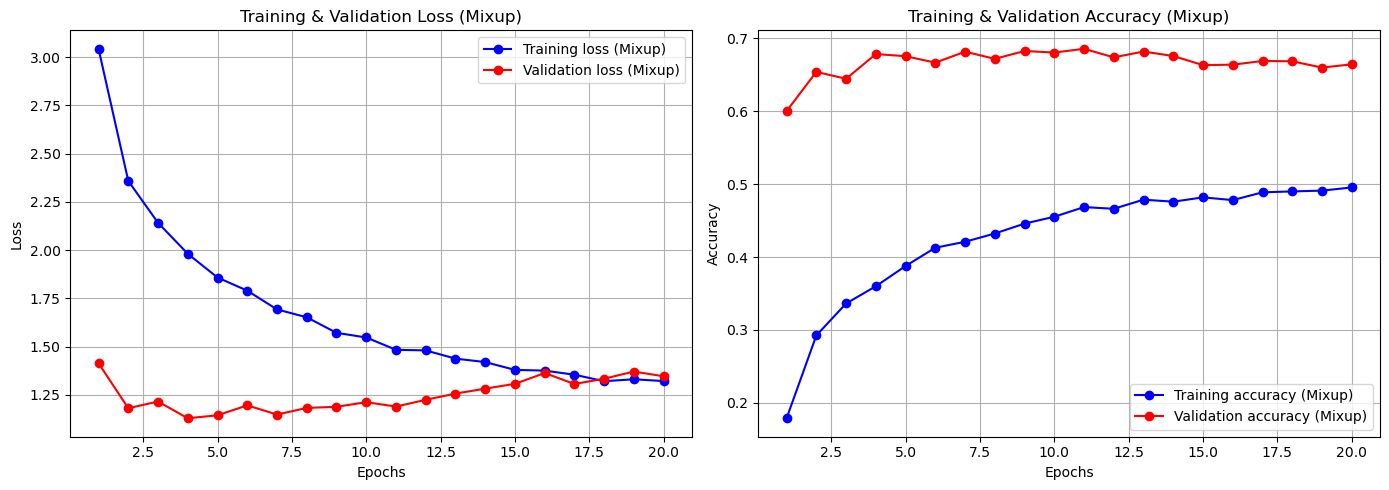

In [87]:
print("\nPlotting Mixup training history...")

train_loss = history_mixup['train_loss']
val_loss = history_mixup['val_loss']
train_acc = history_mixup['train_acc']
val_acc = history_mixup['val_acc']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# (왼쪽) 손실(Loss) 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss (Mixup)')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss (Mixup)')
plt.title('Training & Validation Loss (Mixup)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# (오른쪽) 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy (Mixup)')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy (Mixup)')
plt.title('Training & Validation Accuracy (Mixup)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()